In [3]:
import cv2
vidcap = cv2.VideoCapture('moving_car.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

sec = 0
frameRate = 0.05 #//it will capture image in each 0.05 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import gridspec
from numpy.fft import fft2,ifft2,fftshift,ifftshift
from scipy import signal
import cv2


In [81]:
def Rec(w,h): #rectangle
    L = 160
    aperture = np.zeros(shape = (L,L), dtype = float)
    center = (L/2,L/2)
    for i in np.arange(center[0]-w//2,center[0]+w//2): #width
        for j in np.arange(center[1]-h//2,center[1]+h//2) : #height
            aperture[int(i)][int(j)] = 1
            
    return aperture

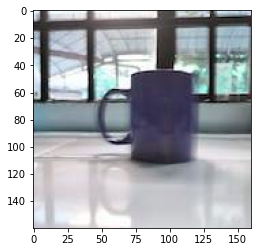

In [102]:
fn = 'cup_blur_2 copy.jpg'
img_bw = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.imread(fn, 1)

plt.imshow(img_bw, cmap = 'gray')
plt.imshow(img_rgb, cmap = 'gray')

In [139]:
img_r = np.zeros_like(img_bw)
img_g = np.zeros_like(img_bw)
img_b = np.zeros_like(img_bw)

img_r = img_rgb[..., 0]
img_g = img_rgb[..., 1]
img_b = img_rgb[..., 2]

img_rgb = np.float32(img_rgb)/255.0
img_bw = np.float32(img_bw)/255.0
img_r = np.float32(img_r)/255.0
img_g = np.float32(img_g)/255.0
img_b = np.float32(img_b)/255.0

img_r = blur_edge(img_r)
img_g = blur_edge(img_g)
img_b = blur_edge(img_b)

# IMG_BW = cv2.dft(img_bw, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_R = cv2.dft(img_r, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_G = cv2.dft(img_g, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_B = cv2.dft(img_b, flags=cv2.DFT_COMPLEX_OUTPUT)


TypeError: Invalid shape (160, 160, 2) for image data

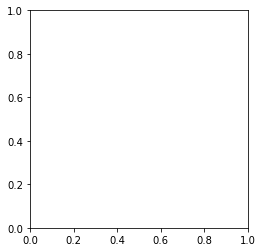

In [140]:
plt.imshow(IMG_R)

In [108]:
win = 'deconvolution'
ang = np.deg2rad( cv2.getTrackbarPos('angle', win))
d = cv2.getTrackbarPos('d', win)

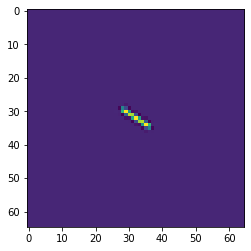

In [113]:
ang = 10
d = 10
psf = motion_kernel(ang, d)
psf /= psf.sum()
plt.imshow(psf)

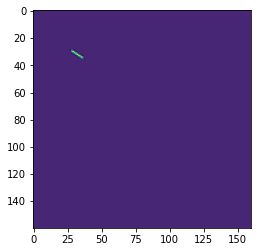

In [116]:
psf_pad = np.zeros_like(img_bw)
kh, kw = psf.shape
psf_pad[:kh, :kw] = psf
plt.imshow(psf_pad)

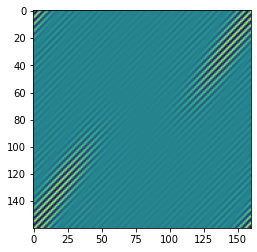

In [129]:
noise = 15
PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
PSF2 = (PSF**2).sum(-1)
iPSF = PSF / (PSF2 + noise)[...,np.newaxis]

plt.imshow(iPSF[:,:,0])

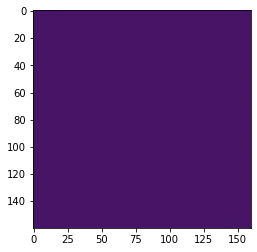

In [138]:

RES_R = cv2.mulSpectrums(IMG_R, iPSF, 0)
RES_G = cv2.mulSpectrums(IMG_G, iPSF, 0)
RES_B = cv2.mulSpectrums(IMG_B, iPSF, 0)


plt.imshow(IMG_R[:,:,0])


res_r = cv2.idft(RES_R, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
res_g = cv2.idft(RES_G, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
res_b = cv2.idft(RES_B, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )

# res_rgb = np.zeros_like(img_rgb)
# res_rgb[..., 0] = res_r
# res_rgb[..., 1] = res_g
# res_rgb[..., 2] = res_b

# res_rgb = np.roll(res_rgb, -kh//2, 0)
# res_rgb = np.roll(res_rgb, -kw//2, 1)



In [14]:
def motion_kernel(angle, d, sz=64):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

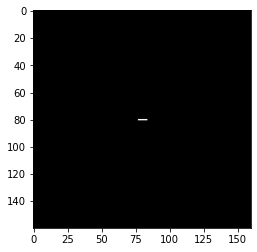

In [39]:
psf = motion_kernel(0, 7, sz=160)
plt.imshow(psf, cmap = 'gray')

Text(0.5, 1.0, 'FFT')

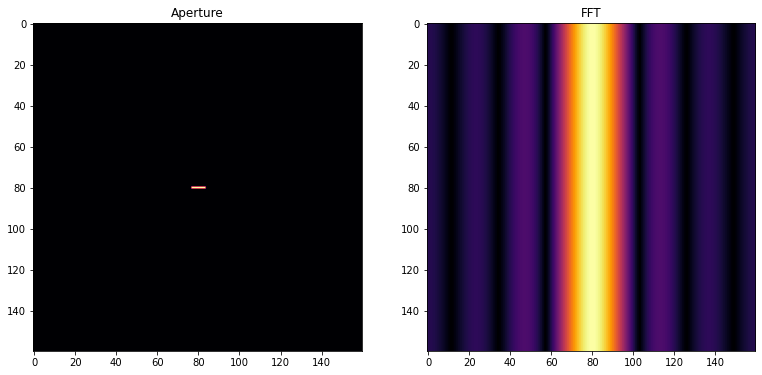

In [40]:
aperture = psf
f = plt.figure(figsize=(20,60))
ax1 = f.add_subplot(131)
ax1.imshow(aperture, cmap ='inferno')
plt.title('Aperture')
ft_aperture = fft2(aperture)
FT_aperture = fftshift(np.abs(ft_aperture))
ax2 = f.add_subplot(132)
ax2.imshow(FT_aperture, cmap ='inferno')
plt.title('FFT')

In [41]:
def FFT(aperture):
    f = plt.figure(figsize=(20,60))
    ax1 = f.add_subplot(131)
    ax1.imshow(aperture, cmap ='inferno')
    plt.title('Aperture')
    ft_aperture = fft2(aperture)
    FT_aperture = fftshift(np.abs(ft_aperture))
    ax2 = f.add_subplot(132)
    ax2.imshow(FT_aperture, cmap ='inferno')
    plt.title('FFT')
    ax3 = f.add_subplot(133)
    ax3.imshow(np.log(FT_aperture), cmap ='inferno')
    plt.title('FFT in log scale')
    

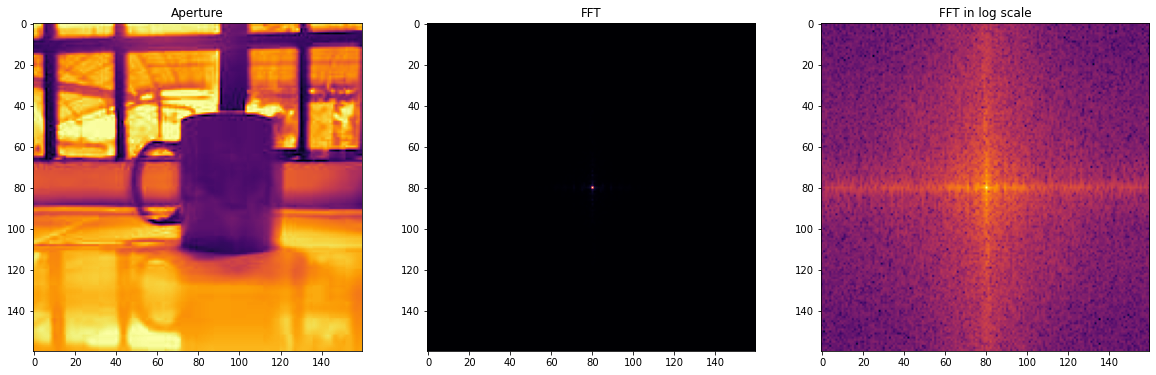

In [42]:
FFT(img)

In [68]:
def Conv(img, aperture):
    f = plt.figure(figsize=(20,60))
    C = fftshift(aperture)
    V = fft2(img)
    Conv = np.abs(ifft2(V*C))
    plt.subplot(131)
    plt.imshow(img, cmap ='inferno')
    plt.subplot(132)
    plt.imshow(aperture, cmap ='inferno')
    plt.subplot(133)
    plt.imshow(Conv, cmap ='inferno')

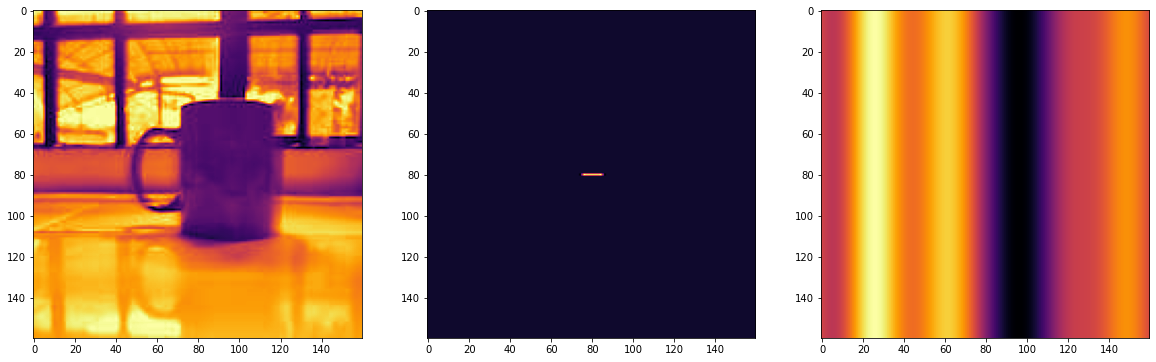

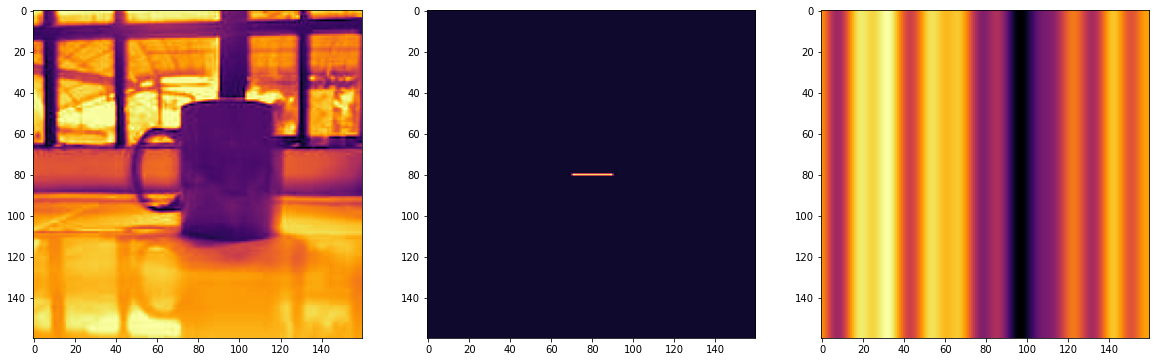

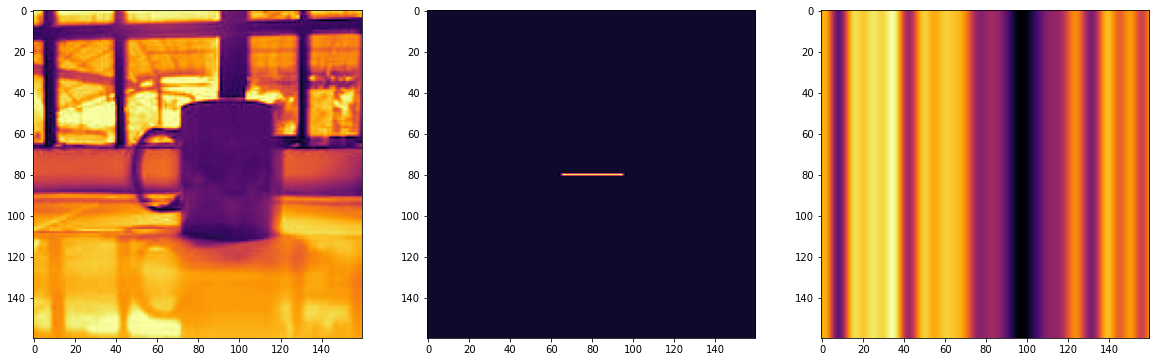

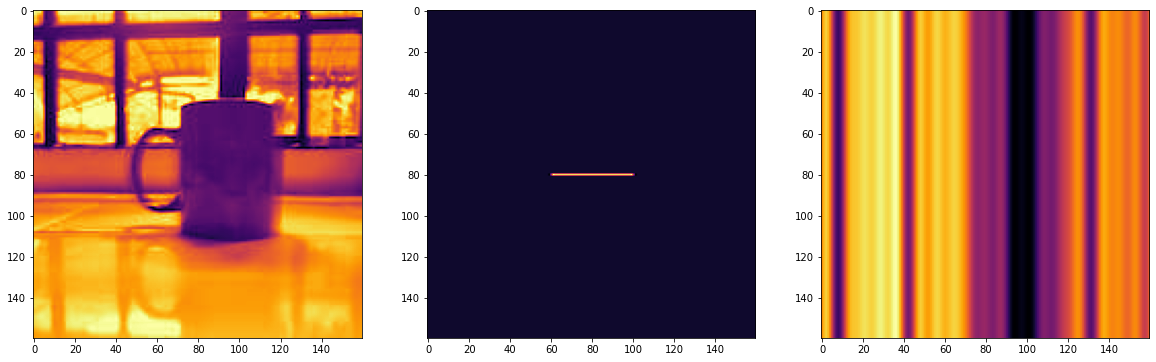

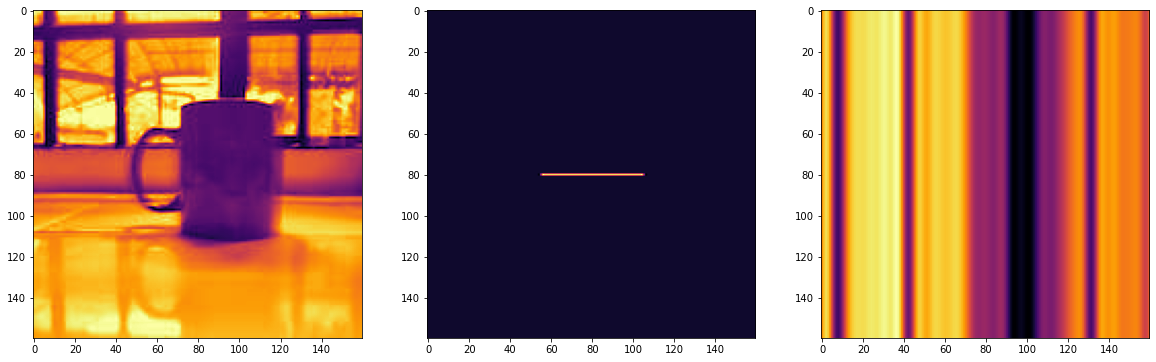

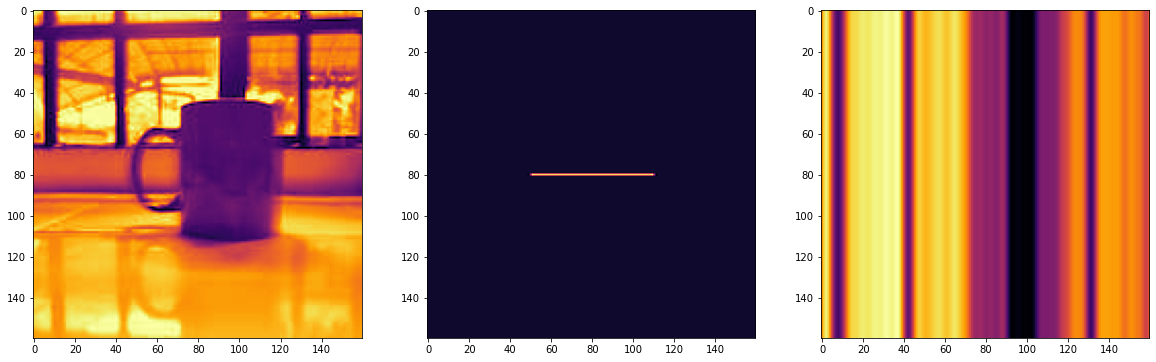

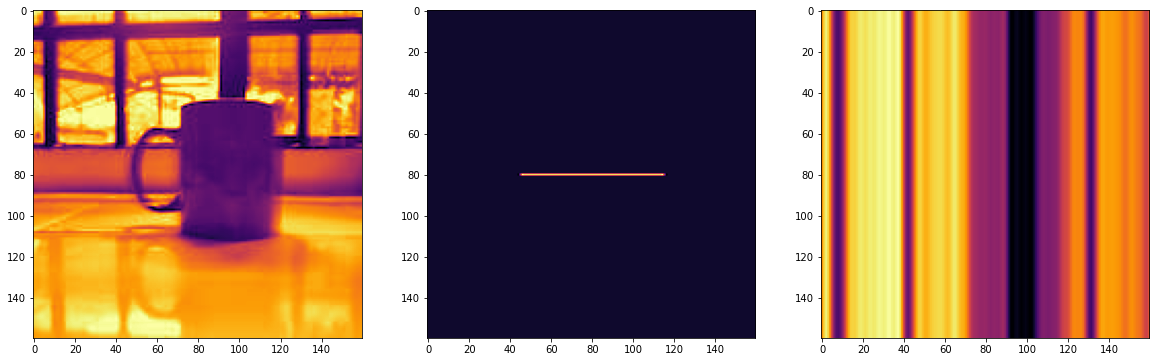

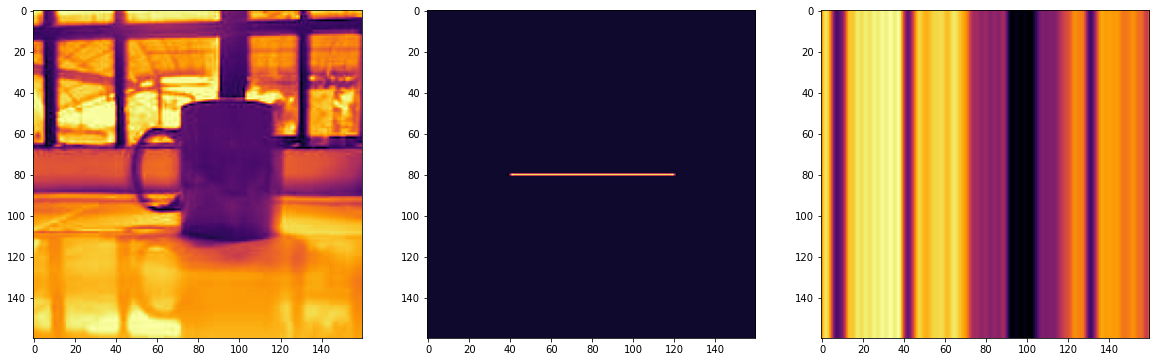

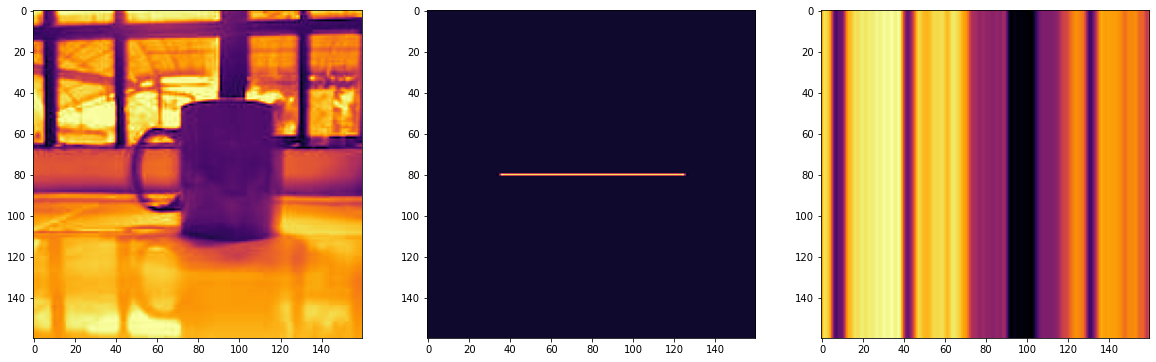

In [69]:
for i in range(1,10):
    psf = motion_kernel(0, i*10, sz=160)
    Conv(img, psf)

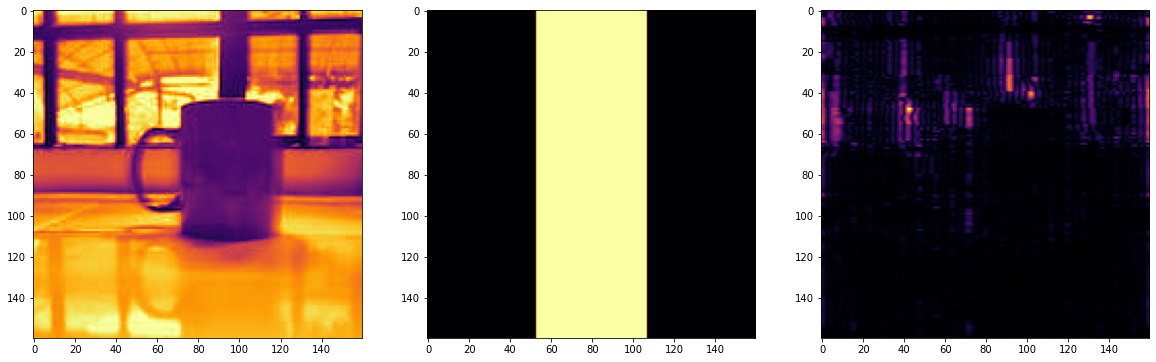

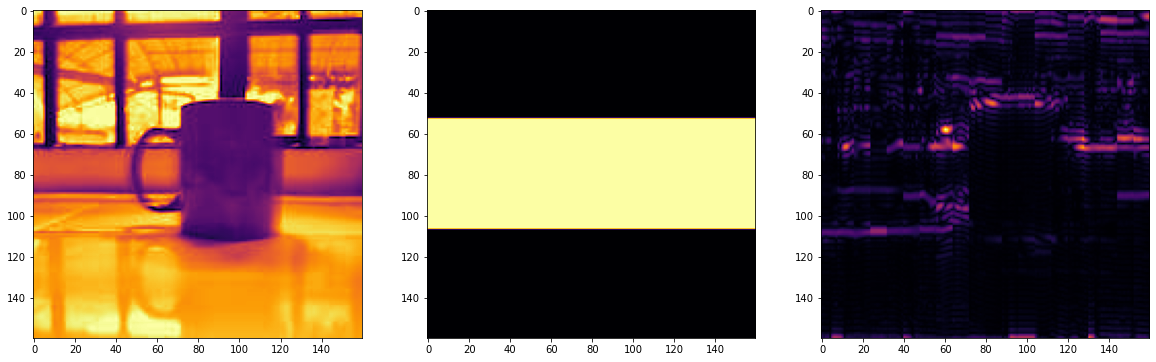

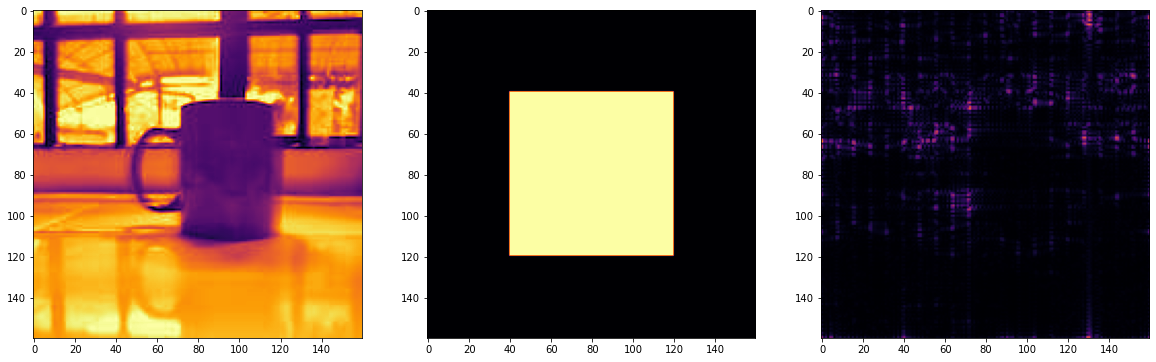

In [84]:
def Edge2(aperture):
    f = plt.figure(figsize=(20,60))
    C = aperture
    V = fft2(img)
    Conv = np.abs(ifft2(V*C))
    plt.subplot(131)
    plt.imshow(img, cmap = 'inferno')
    plt.subplot(132)
    plt.imshow(C, cmap = 'inferno')
    plt.subplot(133)
    plt.imshow(Conv, cmap = 'inferno')
    
Edge2(Rec(160,55))
Edge2(Rec(55, 160))
Edge2(Rec(80,80))

In [80]:
Rec(160,85)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:
import numpy as np
from scipy.signal import fftconvolve

def richardson_lucy_blind(image, psf, original, num_iter=50):    
    im_deconv = np.full(image.shape, 0.1, dtype='float')    # init output
    for i in range(num_iter):
        psf_mirror = np.flip(psf)
        conv = fftconvolve(im_deconv, psf, mode='same')
        relative_blur = image / conv
        im_deconv *= fftconvolve(relative_blur, psf_mirror, mode='same')
        im_deconv_mirror = np.flip(im_deconv)
        psf *= fftconvolve(relative_blur, im_deconv_mirror, mode='same')    
    return im_deconv

In [92]:

xx = richardson_lucy_blind(img, psf, img, num_iter=50)

/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_14164/1547346938.py:12: RuntimeWarning: overflow encountered in multiply
  psf *= fftconvolve(relative_blur, im_deconv_mirror, mode='same')


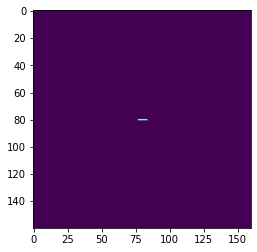

In [94]:
psf = motion_kernel(0, 7, sz=160)

plt.imshow(psf)

In [97]:

from __future__ import print_function

import numpy as np
import cv2

# local module
# from common import nothing


def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

def motion_kernel(angle, d, sz=65):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

def defocus_kernel(d, sz=65):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.CV_AA, shift=1)
    kern = np.float32(kern) / 255.0
    return 
if __name__ == '__main__':
    print(__doc__)
    import sys, getopt
    opts, args = getopt.getopt(sys.argv[1:], '', ['circle', 'angle=', 'd=', 'snr='])
    opts = dict(opts)
    try:
        fn = args[0]
    except:
        fn = './sample.png'

    win = 'deconvolution'

    img_bw = cv2.imread(fn, 0)
    img_rgb = cv2.imread(fn, 1)

    if img_bw is None and img_rgb is None:
        print('Failed to load image:', fn)
        sys.exit(1)

    img_r = np.zeros_like(img_bw)
    img_g = np.zeros_like(img_bw)
    img_b = np.zeros_like(img_bw)

    img_r = img_rgb[..., 0]
    img_g = img_rgb[..., 1]
    img_b = img_rgb[..., 2]

    img_rgb = np.float32(img_rgb)/255.0
    img_bw = np.float32(img_bw)/255.0
    img_r = np.float32(img_r)/255.0
    img_g = np.float32(img_g)/255.0
    img_b = np.float32(img_b)/255.0

    cv2.imshow('input', img_rgb)

    # img_bw = blur_edge(img_bw)
    img_r = blur_edge(img_r)
    img_g = blur_edge(img_g)
    img_b = blur_edge(img_b)

    # IMG_BW = cv2.dft(img_bw, flags=cv2.DFT_COMPLEX_OUTPUT)
    IMG_R = cv2.dft(img_r, flags=cv2.DFT_COMPLEX_OUTPUT)
    IMG_G = cv2.dft(img_g, flags=cv2.DFT_COMPLEX_OUTPUT)
    IMG_B = cv2.dft(img_b, flags=cv2.DFT_COMPLEX_OUTPUT)

    defocus = '--circle' in opts

    def update(_):
        ang = np.deg2rad( cv2.getTrackbarPos('angle', win) )
        d = cv2.getTrackbarPos('d', win)
        noise = 10**(-0.1*cv2.getTrackbarPos('SNR (db)', win))

        if defocus:
            psf = defocus_kernel(d)
        else:
            psf = motion_kernel(ang, d)
        cv2.imshow('psf', psf)

        psf /= psf.sum()
        psf_pad = np.zeros_like(img_bw)
        kh, kw = psf.shape
        psf_pad[:kh, :kw] = psf
        PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
        PSF2 = (PSF**2).sum(-1)
        iPSF = PSF / (PSF2 + noise)[...,np.newaxis]

        # RES_BW = cv2.mulSpectrums(IMG_BW, iPSF, 0)
        RES_R = cv2.mulSpectrums(IMG_R, iPSF, 0)
        RES_G = cv2.mulSpectrums(IMG_G, iPSF, 0)
        RES_B = cv2.mulSpectrums(IMG_B, iPSF, 0)


        # res_bw = cv2.idft(RES_BW, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
        res_r = cv2.idft(RES_R, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
        res_g = cv2.idft(RES_G, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
        res_b = cv2.idft(RES_B, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )

        res_rgb = np.zeros_like(img_rgb)
        res_rgb[..., 0] = res_r
        res_rgb[..., 1] = res_g
        res_rgb[..., 2] = res_b

        # res_bw = np.roll(res_bw, -kh//2, 0)
        # res_bw = np.roll(res_bw, -kw//2, 1)
        res_rgb = np.roll(res_rgb, -kh//2, 0)
        res_rgb = np.roll(res_rgb, -kw//2, 1)
        cv2.imshow(win, res_rgb)

    cv2.namedWindow(win)
    cv2.namedWindow('psf', 0)
    cv2.createTrackbar('angle', win, int(opts.get('--angle', 135)), 180, update)
    cv2.createTrackbar('d', win, int(opts.get('--d', 22)), 50, update)
    cv2.createTrackbar('SNR (db)', win, int(opts.get('--snr', 25)), 50, update)
    update(None)

    while True:
        ch = cv2.waitKey() & 0xFF
        if ch == 27:
            break
        if ch == ord(' '):
            defocus = not defocus
            update(None)

Automatically created module for IPython interactive environment


GetoptError: option -f not recognized